In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.distributions import Normal
from tensorflow.distributions import Bernoulli

In [2]:
class DenseLayer(object):
    '''A fully connected layer'''
    def __init__(self, n_in, n_out, activation=tf.nn.relu):
        '''number of input and output neurons, and the activation function'''
        self.weights = tf.Variable(tf.random_normal(shape=(n_in, n_out), stddev=2/np.sqrt(n_in)))
        self.bias = tf.Variable(tf.constant(0.0,shape=[n_out]))
        if (activation=='none'):
            self.activation = lambda x: x
        else:
            self.activation = activation
            
    def feed_forward(self, X):
        # run input through layer and retrieve output
        return self.activation(tf.matmul(X, self.weights) + self.bias)

In [7]:
class VariationalAutoencoder:
    def __init__(self, n_input, n_list):
        ''''''
        # input
        self.X = tf.placeholder(tf.float32, shape=(None, n_input))
        
        # encoder
        # build hidden layers
        self.encoder_layers = []
        # input of first hidden layer
        previous = n_input
        # current is the output of each layer (skip last because there is nothing after it)
        for current in n_list[:-1]:
            # hidden layer
            h = DenseLayer(previous,current)
            self.encoder_layers.append(h)
            previous = current
        # latent features number
        latent = n_list[-1]
        encoder_output = DenseLayer(current,latent*2,activation='none')
        self.encoder_layers.append(encoder_output)
        
        # feed forward through encoder
        c_X = self.X
        for layer in self.encoder_layers:
            c_X = layer.feed_forward(c_X)
        # c_X now holds the output of the encoder
        self.means = c_X[:,:latent]
        # std must be positive, 1e-6 for smoothing
        self.std = tf.nn.softplus(c_X[:,latent:]) + 1e-6
        
        # reparameterization trick
        normal = Normal(loc=self.means,scale=self.std)
        self.Z = normal.sample()
        
        
        # decoder
        self.decoder_layers = []
        previous = latent
        for current in reversed(n_list[:-1]):
            h = DenseLayer(previous,current)
            self.decoder_layers.append(h)
            previous = current
        decoder_output = DenseLayer(previous,n_input,activation=lambda x:x)
        self.decoder_layers.append(decoder_output)

        #feed forward through decoder
        c_X = self.Z
        for layer in self.decoder_layers:
            c_X = layer.feed_forward(c_X)
        logits = c_X
        # save for cost function below
        neg_cross_entropy = -tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X,
                    logits=logits)
        neg_cross_entropy = tf.reduce_sum(neg_cross_entropy, 1)
        
        # output
        self.pred = Bernoulli(logits=logits)
        
        # sample from output
        self.post_pred = self.pred.sample()
        self.post_pred_probs = tf.nn.sigmoid(logits)
        
        scale = np.ones(latent,dtype=np.float32)
        loc = scale*0
        std_norm = Normal(loc,scale)
        
        Z_std = std_norm.sample(1)
        c_X = Z_std
        for layer in self.decoder_layers:
            c_X = layer.feed_forward(c_X)
        logits = c_X
        
        prior_pred_dist = Bernoulli(logits=logits)
        self.prior_pred = prior_pred_dist.sample()
        self.prior_pred_probs = tf.nn.sigmoid(logits)
        
        self.Z_input = tf.placeholder(np.float32, shape=(None, latent))
        c_X = self.Z_input
        for layer in self.decoder_layers:
            c_X = layer.feed_forward(c_X)
        logits = c_X
        self.prior_pred_from_in_probs = tf.nn.sigmoid(logits)
        
        # cost
        # Kullback–Leibler divergence
        kl = -tf.log(self.std) + 0.5*(self.std**2 + self.means**2) - 0.5
        kl = tf.reduce_sum(kl, axis=1)
        # ELBO
        self.elbo = tf.reduce_sum(neg_cross_entropy - kl)
         
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-self.elbo)
               
        self.init = tf.global_variables_initializer()
        self.session = tf.Session()
        self.session.run(self.init)
        
    def fit(self,X,epochs=10,batch=50):
        costs = []
        n_batches = len(X) // batch
        for epoch in range(epochs):
            print('Epoch:',epoch+1)
            np.random.shuffle(X)
            for b in range(n_batches):
                c_batch = X[b*batch:(b+1)*batch]
                _,c, = self.session.run((self.optimizer, self.elbo),feed_dict={self.X: c_batch})
                # normalize cost
                c/=batch
                costs.append(c)
        plt.plot(costs)
        plt.show()
    
    def transform(self,X):
        return self.session.run(self.means,feed_dict={self.X: X})

In [14]:
data = np.genfromtxt('train.csv', delimiter=',')

In [15]:
X = data[1:,1:]
y = data[1:,0]
X/=255
X = (X>0.5).astype(np.float32)

In [19]:
vae = VariationalAutoencoder(784, [200, 100])

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


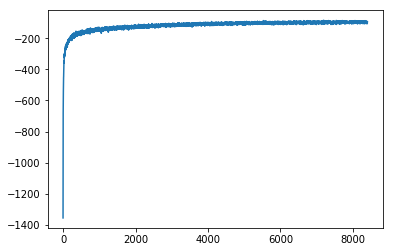

In [20]:
vae.fit(X)

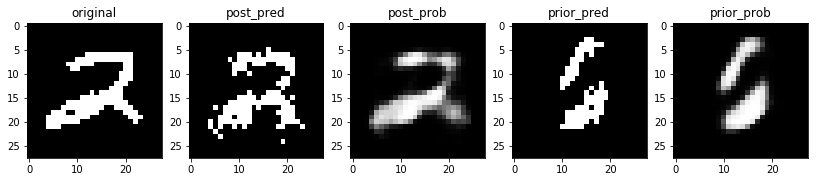

In [48]:
fig,axes = plt.subplots(ncols=5,figsize=(14,14))

i = np.random.choice(len(X))
a = vae.session.run(vae.post_pred,feed_dict={vae.X:[X[i]]}).reshape(28,28)
b = vae.session.run(vae.post_pred_probs,feed_dict={vae.X:[X[i]]}).reshape(28,28)
c,d = vae.session.run((vae.prior_pred,vae.prior_pred_probs))
c,d = c.reshape(28,28), d.reshape(28,28)

axes[0].imshow(X[i].reshape(28,28),cmap='gray')
axes[0].set_title('original')
axes[1].imshow(a,cmap='gray')
axes[1].set_title('post_pred')
axes[2].imshow(b,cmap='gray')
axes[2].set_title('post_prob')
axes[3].imshow(c,cmap='gray')
axes[3].set_title('prior_pred')
axes[4].imshow(d,cmap='gray')
axes[4].set_title('prior_prob')
plt.show()

In [111]:
Z_input = np.random.normal(size=100)

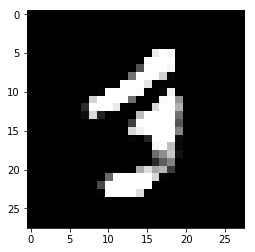

In [122]:
# add noise
ZZ = Z_input.copy()
ZZ[10:20]-=10
im = vae.session.run(vae.prior_pred_from_in_probs,feed_dict={vae.Z_input:[ZZ]}).reshape(28,28)
plt.imshow(im,cmap='gray')
plt.show()